In [12]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
import marimo as mo
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [13]:
# pip install scikit-learn

In [14]:
cities = pd.read_csv('city.csv')
print(cities.head())

calendar = pd.read_csv('Calendar.csv')
calendar['calendar_date'] = pd.to_datetime(calendar['calendar_date'])
print(calendar.head())

passengers = pd.read_csv('passenger.csv')
passengers['first_call_time'] = pd.to_datetime(passengers['first_call_time'], errors='coerce')

passengers['date_only'] = passengers['first_call_time'].dt.date
passengers['date_only'] = pd.to_datetime(passengers['date_only'])
passengers = passengers.merge(
    calendar[['calendar_date', 'holiday']], 
    left_on='date_only', 
    right_on='calendar_date', 
    how='left'
)


      id          name
0  42868        Mordor
1  42948        Erebor
2  43006  Minas Tirith
3  43020      Isengard
4  43050        Gondor
      id calendar_date   week_day  holiday
0  46724    2018-01-01     Monday        1
1  46725    2018-01-02    Tuesday        0
2  46726    2018-01-03  Wednesday        0
3  46727    2018-01-04   Thursday        0
4  46728    2018-01-05     Friday        0


In [ ]:
trips = pd.read_csv('trip.csv')

In [4]:
trips.isna().sum()

id                   0
driver_id            0
passenger_id         0
city_id              0
call_time            0
finish_time          0
surge_rate           6
trip_distance    23239
trip_fare            0
dtype: int64

In [5]:
# trips.trip_distance.fillna(trips.trip_distance.mean())

0           1.92
1           9.36
2           4.39
3           2.04
4           7.37
           ...  
2318352     4.72
2318353    20.20
2318354     8.78
2318355     3.40
2318356     9.99
Name: trip_distance, Length: 2318357, dtype: float64

In [6]:
trips['call_time'] = pd.to_datetime(trips['call_time'])
trips['finish_time'] = pd.to_datetime(trips['finish_time'])

trips['trip_duration'] = (trips['finish_time'] - trips['call_time']).dt.total_seconds() / 60

trips['call_hour'] = trips['call_time'].dt.hour
trips['call_weekday'] = trips['call_time'].dt.weekday
trips['call_month'] = trips['call_time'].dt.month
trips['call_date'] = trips['call_time'].dt.date
trips['call_date'] = pd.to_datetime(trips['call_date'])

In [7]:
trips = trips.merge(cities, left_on='city_id', right_on='id', how='left', suffixes=('', '_city'))
trips.rename(columns={'name': 'city_name'}, inplace=True)

In [8]:
trips = trips.merge(
    calendar[['calendar_date', 'holiday', 'week_day']],
    left_on='call_date',
    right_on='calendar_date',
    how='left'
)

In [9]:
trips.groupby(['city_name']).count()

,id,driver_id,passenger_id,city_id,call_time,finish_time,surge_rate,trip_distance,trip_fare,trip_duration,call_hour,call_weekday,call_month,call_date,id_city,calendar_date,holiday,week_day
city_name,,,,,,,,,,,,,,,,,,
Gondor,318499,318499,318499,318499,318499,318499,318499,315258,318499,318499,318499,318499,318499,318499,318499,318499,318499,318499
Isengard,337648,337648,337648,337648,337648,337648,337647,334237,337648,337648,337648,337648,337648,337648,337648,337648,337648,337648
Minas Tirith,418895,418895,418895,418895,418895,418895,418893,414613,418895,418895,418895,418895,418895,418895,418895,418895,418895,418895
Rivendell,388464,388464,388464,388464,388464,388464,388463,384649,388464,388464,388464,388464,388464,388464,388464,388464,388464,388464
Rohan,365397,365397,365397,365397,365397,365397,365397,361807,365397,365397,365397,365397,365397,365397,365397,365397,365397,365397
The Shire,489454,489454,489454,489454,489454,489454,489452,484554,489454,489454,489454,489454,489454,489454,489454,489454,489454,489454


In [10]:
trips['is_weekend'] = trips['week_day'].isin(['Sunday', 'Saturday']).astype(int)
trips['speed'] = trips['trip_distance'] / trips['trip_duration']
city_counts = trips['id_city'].value_counts()


In [44]:
trips.drop_duplicates

<bound method DataFrame.drop_duplicates of                id driver_id passenger_id  city_id           call_time  \
0        a84c0db2  cb64172e     2ea4359d    43006 2019-09-08 22:01:28   
1        a84c2d10  3034e6fe     e1bd0c8d    43006 2019-07-01 20:56:28   
2        a84c3e75  93fb6802     75e6d450    43050 2019-08-20 21:30:46   
3        a84c3f6f  25fc9273     5ba48e89    43020 2019-09-08 02:42:41   
4        a84c5ce2  484c4d0c     fdb2ef59    43006 2019-06-10 09:29:18   
...           ...       ...          ...      ...                 ...   
2318352  a84b949e  a454c95d     906eee37    43006 2019-07-06 06:32:54   
2318353  a84bc1e0  1a154fe4     313bd7fe    43050 2019-07-22 17:58:25   
2318354  a84bcd75  9e8e5eb2     47253b43    43050 2019-09-07 18:24:18   
2318355  a84bde9a  e609e0a3     b731ab38    43006 2019-07-02 18:24:59   
2318356  a84be654  308ccf8f     15a309cb    43179 2019-09-07 09:15:50   

                finish_time  surge_rate  trip_distance  trip_fare  \
0       201

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(max_depth=5),
    'RandomForest': RandomForestRegressor(n_estimators=100),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100)
}

In [ ]:
features = [
    'trip_distance',        # Основной предиктор
    'surge_rate',           # Коэффициент повышения
    'hour_of_day',          # Время суток
    'is_weekend',           # Выходной/будний
    'trip_duration'         # Длительность поездки
]

In [ ]:
trips_clean = trips.dropna(subset=['trip_fare', 'surge_rate', 'trip_distance'])

print(trips_clean.shape)
print(trips_clean.head())

feature_cols_trips = ['trip_distance', 'trip_duration', 'surge_rate',
                      'call_hour', 'call_weekday', 'call_month', 'holiday', 'is_weekend', 'id_city', 'speed']


X = trips_clean[feature_cols_trips]
y = trips_clean['trip_fare']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
model_fare = GradientBoostingRegressor()
model_fare.fit(X_train, y_train)

In [ ]:

# Создание пайплайна
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())  # Модель будет меняться
])

In [41]:
trips_clean = trips.dropna(subset=['trip_fare', 'surge_rate', 'trip_distance'])

print(trips_clean.shape)
print(trips_clean.head())

feature_cols_trips = ['trip_distance', 'trip_duration', 'surge_rate',
                      'call_hour', 'call_weekday', 'call_month', 'holiday', 'is_weekend', 'id_city', 'speed']


X_fare = trips_clean[feature_cols_trips]
y_trips_fare = trips_clean['trip_fare']

X_train_fare, X_test_fare, y_train_fare, y_test_fare = train_test_split(
    X_fare, y_trips_fare, test_size=0.4, random_state=42
)
model_fare = GradientBoostingRegressor()
model_fare.fit(X_train_fare, y_train_fare)

y_pred_fare = model_fare.predict(X_test_fare)

print(f'\nМетрики качества модели GradientBoostingRegressor:')
print(f'  MAE (Mean Absolute Error): {mean_absolute_error(y_test_fare, y_pred_fare):.4f}')
print(f'  RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_test_fare, y_pred_fare)):.4f}')
print(f'  R² Score: {r2_score(y_test_fare, y_pred_fare):.4f}')


(2295112, 21)
         id driver_id passenger_id  city_id           call_time  \
0  a84c0db2  cb64172e     2ea4359d    43006 2019-09-08 22:01:28   
1  a84c2d10  3034e6fe     e1bd0c8d    43006 2019-07-01 20:56:28   
2  a84c3e75  93fb6802     75e6d450    43050 2019-08-20 21:30:46   
3  a84c3f6f  25fc9273     5ba48e89    43020 2019-09-08 02:42:41   
4  a84c5ce2  484c4d0c     fdb2ef59    43006 2019-06-10 09:29:18   

          finish_time  surge_rate  trip_distance  trip_fare  trip_duration  \
0 2019-09-08 22:15:54         0.3           1.92       4.36      14.433333   
1 2019-07-01 21:22:09         0.0           9.36       6.91      25.683333   
2 2019-08-20 21:46:48         0.0           4.39       3.48      16.033333   
3 2019-09-08 02:59:56         0.0           2.04       1.54      17.250000   
4 2019-06-10 09:55:36         0.0           7.37       5.83      26.300000   

   ...  call_weekday  call_month  call_date id_city     city_name  \
0  ...             6           9 2019-09-08  

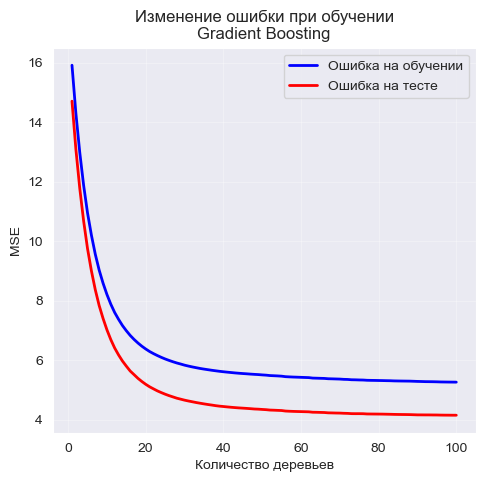

In [13]:
train_errors = model_fare.train_score_
test_errors = []
for i, y_pred in enumerate(model_fare.staged_predict(X_test_fare)):
    test_errors.append(mean_squared_error(y_test_fare, y_pred))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_errors) + 1), train_errors, 'b-', label='Ошибка на обучении', linewidth=2)
plt.plot(range(1, len(test_errors) + 1), test_errors, 'r-', label='Ошибка на тесте', linewidth=2)
plt.xlabel('Количество деревьев')
plt.ylabel('MSE')
plt.title('Изменение ошибки при обучении\nGradient Boosting')
plt.legend()
plt.grid(True, alpha=0.3)


In [43]:
model_fare.feature_importances_

array([8.11482549e-01, 1.07983382e-01, 6.77051009e-02, 2.88652221e-05,
       0.00000000e+00, 4.70121618e-04, 0.00000000e+00, 0.00000000e+00,
       8.24881370e-03, 4.08116785e-03])

In [30]:
# model_fare = LinearRegression()
# model_fare.fit(X_train_fare, y_train_fare)
#
# y_pred_fare = model_fare.predict(X_test_fare)
#
# print(f'\nМетрики качества модели LinearRegression:')
# print(f'  MAE (Mean Absolute Error): {mean_absolute_error(y_test_fare, y_pred_fare):.4f}')
# print(f'  RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_test_fare, y_pred_fare)):.4f}')
# print(f'  R² Score: {r2_score(y_test_fare, y_pred_fare):.4f}')
#
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test_fare, y_pred_fare, alpha=0.5, color='b')
# plt.plot([y_test_fare.min(), y_test_fare.max()], [y_test_fare.min(), y_test_fare.max()], 'k--', lw=2)
# plt.xlabel('Фактические значения')
# plt.ylabel('Предсказанные значения')
# plt.title('Фактические vs Предсказанные значения')
# plt.show()

In [37]:
from sklearn.model_selection import cross_validate
scoring = {'neg_RMSE': 'neg_root_mean_squared_error',
          'neg_MAE': 'neg_mean_absolute_error',
           'r2':'r2'}
scores = cross_validate(model_fare, X_train_fare, y_train_fare, cv=5, scoring=scoring)

In [38]:
scores

{'fit_time': array([0.39552069, 0.41126347, 0.38241291, 0.37171316, 0.44144273]),
 'score_time': array([0.03535485, 0.04004478, 0.02914667, 0.02747512, 0.0243454 ]),
 'test_neg_RMSE': array([-2.21771819, -3.22093973, -2.2841256 , -2.20908149, -2.26761945]),
 'test_neg_MAE': array([-1.44074018, -1.44678112, -1.44733121, -1.44652684, -1.44469545]),
 'test_r2': array([0.69983606, 0.53036842, 0.69602456, 0.70438721, 0.70092913])}